In [245]:
import xgboost
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# from sklearn.base import BaseEstimator, TransformerMixin # Needed to do custom pipeline things

In [2]:
features_race = ['white_alone_percent_cen', 'black_alone_percent_cen',
       'indigenous_alone_percent_cen', 'asian_alone_percent_cen',
       'pacific_islander_alone_percent_cen', 'other_alone_percent_cen',
       'multiracial_percent_cen']

features_transit_type = ['work_from_home_percent_cen',
       'automobile_to_work_percent_cen', 'public_transit_to_work_percent_cen',
       'taxi_to_work_percent_cen', 'motorcycle_to_work_percent_cen',
       'bike_to_work_percent_cen', 'walk_to_work_percent_cen',
       'other_to_work_percent_cen']

features_education = ['lt_9th_percent_cen',
       'no_diploma_percent_cen', 'high_school_percent_cen',
       'some_college_percent_cen', 'associates_percent_cen',
       'bachelors_percent_cen', 'graduate_degree_percent_cen']

features_employment = ['in_labor_force_20_64_percent_cen',
       'not_in_labor_force_20_64_percent_cen', 'unemployed_20_64_percent_cen',
       'below_poverty_line_percent_cen']

features = features_race + features_transit_type + features_education + features_employment + ['median_household_income_cen',
       'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 'driving_travel_time']

Here, we read in the training dataset.

In [3]:
data = gpd.read_file('../project_data/final_dataset/train_final_dataset_Chicago_no_outlier.geojson')
X= data[features]
y= data['VoterTurnoutPercentage'].values

In [43]:
data_train, data_val = train_test_split(data, test_size=0.2)
X_train, y_train = data_train[features], data_train['VoterTurnoutPercentage']
X_val, y_val = data_val[features], data_val['VoterTurnoutPercentage']
# X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.20)

# Features vs VoterTurnoutPercentage

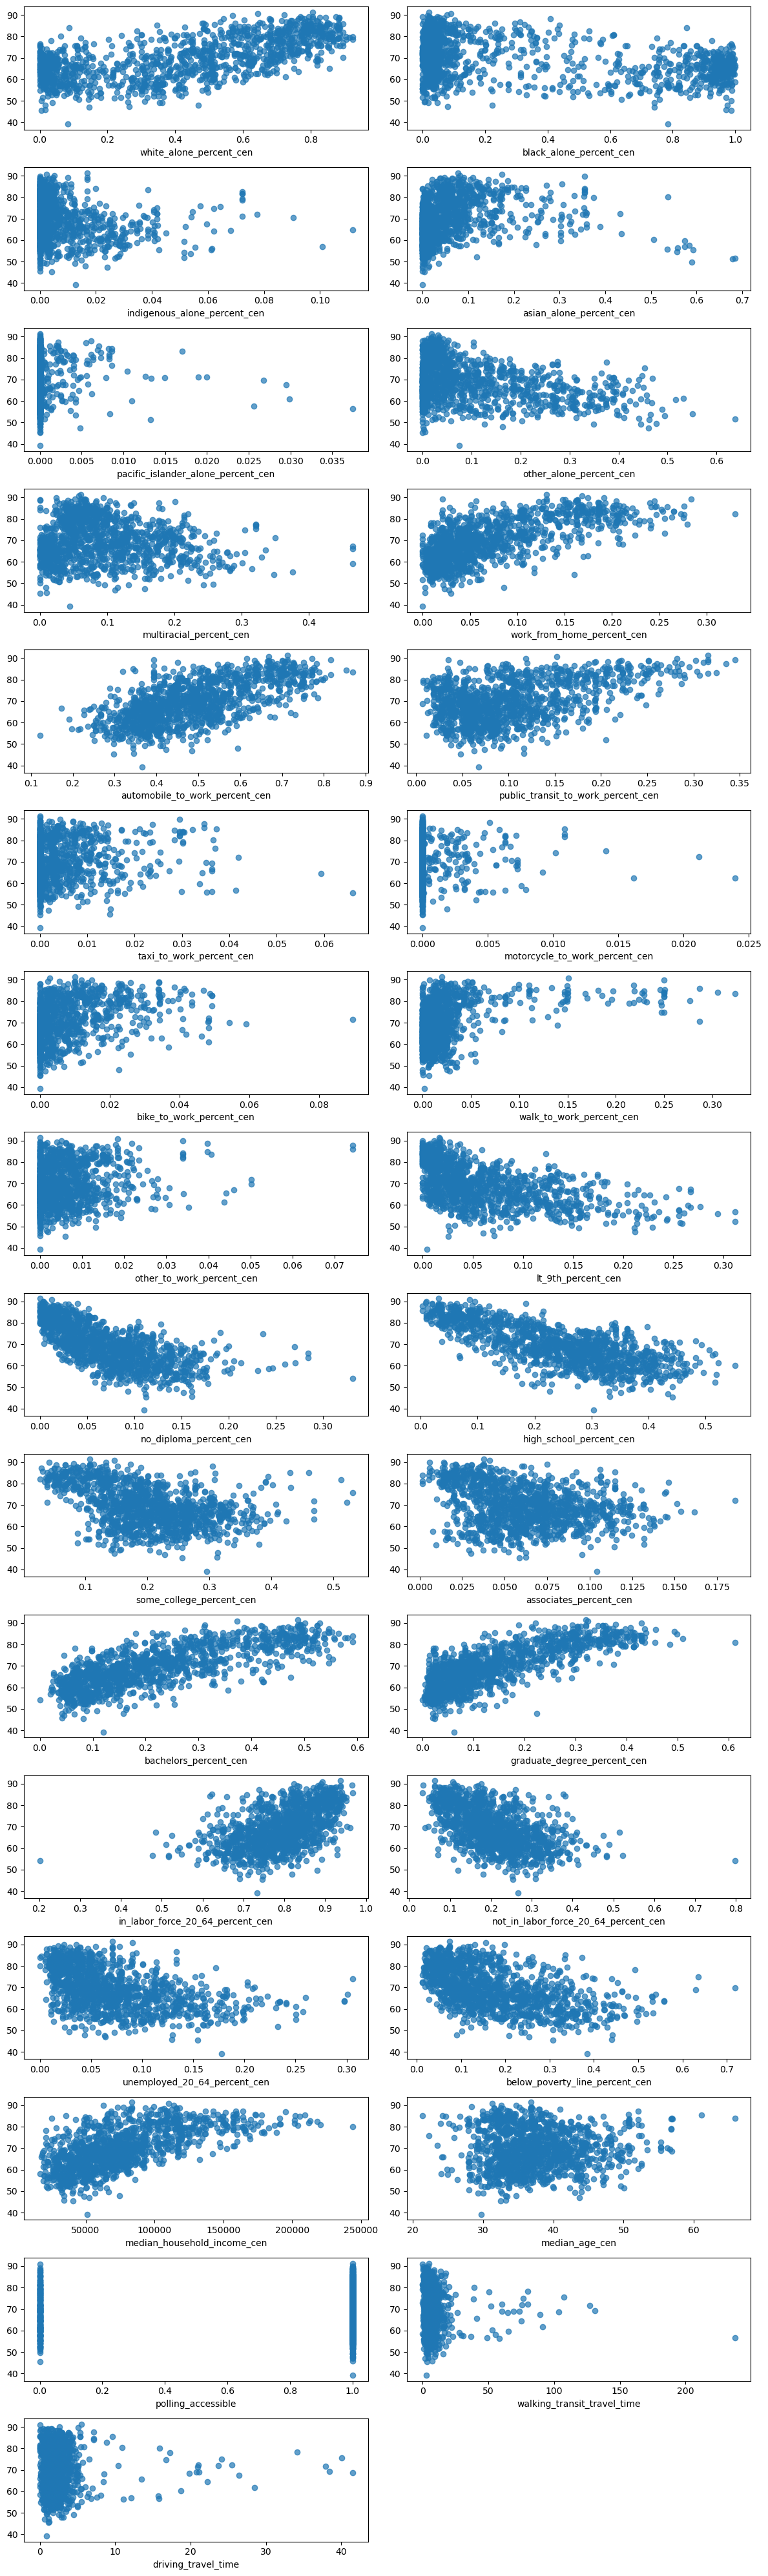

In [224]:
# Define the number of rows and columns for the grid
num_features = X_train.shape[1]
num_cols = 2  # Choose number of columns for layout
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate rows needed

# Create the grid of plots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8 + num_rows * 2))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature against y_train
for i, column in enumerate(X_train.columns):
    axes[i].scatter(X_train[column], y_train.values, alpha=0.7)
    # axes[i].set_title(f'{column} vs VoterTurnoutPercentage')
    axes[i].set_xlabel(column)
    # axes[i].set_ylabel('VoterTurnoutPercentage')

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

# Baseline model

In [5]:
class baseline():
    def __init__(self):
        self.y_predict = None
    def fit(self, X_train,y_train):

        self.y_predict = np.mean(y_train)

    def predict(self, X_predict):
        return self.y_predict * np.ones(len(X_predict))
        

        
        
    

In [6]:

base = baseline()
base.fit(X_train, y_train)
y_predict_base = base.predict(X_val)
rmse_base = root_mean_squared_error(y_predict_base, y_val)
print(rmse_base)

10.230259404351026


So the number to beat is ~9-10% (after rerunning a few times)

# Linear regression

In [42]:
pipe_lr = Pipeline([('scale',StandardScaler()),('reg',LinearRegression())])
pipe_lr.fit(X_train,y_train)
y_predict_lr = pipe_lr.predict(X_val)
rmse_lr = root_mean_squared_error(y_predict_lr, y_val)
print(rmse_lr)

4.774972488733713


# XGBoost

In [8]:
xgb_reg = xgboost.XGBRegressor(learning_rate=.05,
                                   max_depth=5,
                                   n_estimators=100,verbosity=3)
xgb_reg.fit(X_train, y_train,eval_set=[(X_val, y_val)])
y_predict_xgb = xgb_reg.predict(X_val)
rmse_xgb = root_mean_squared_error(y_predict_xgb, y_val)


[10:38:44] ======== Monitor (0): HostSketchContainer ========
[10:38:44] AllReduce: 0.000664s, 1 calls @ 664us

[10:38:44] MakeCuts: 0.000789s, 1 calls @ 789us

[10:38:44] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1724807611129/work/src/gbm/gbtree.cc:130: Using tree method: 0
[0]	validation_0-rmse:9.93935
[1]	validation_0-rmse:9.65619
[2]	validation_0-rmse:9.40672
[3]	validation_0-rmse:9.17162
[4]	validation_0-rmse:8.96421
[5]	validation_0-rmse:8.75342
[6]	validation_0-rmse:8.55678
[7]	validation_0-rmse:8.38638
[8]	validation_0-rmse:8.21835
[9]	validation_0-rmse:8.05593
[10]	validation_0-rmse:7.92483
[11]	validation_0-rmse:7.80009
[12]	validation_0-rmse:7.67484
[13]	validation_0-rmse:7.57115
[14]	validation_0-rmse:7.47239
[15]	validation_0-rmse:7.37432
[16]	validation_0-rmse:7.29185
[17]	validation_0-rmse:7.20850
[18]	validation_0-rmse:7.13913
[19]	validation_0-rmse:7.06867
[20]	validation_0-rmse:7.01317
[21]	validation_0-rmse:6.93143
[22]	validation_0-rmse:6.88160
[23]	v

In [9]:
print(rmse_xgb)

6.237206633074741


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

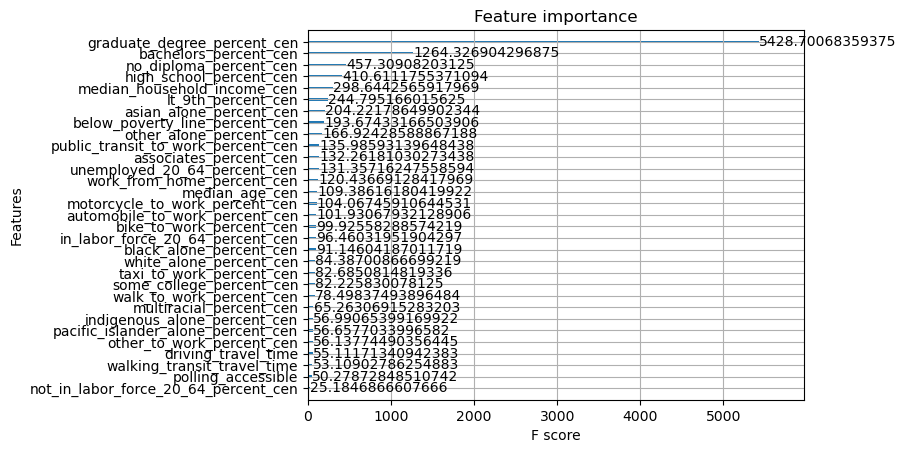

In [10]:
xgboost.plot_importance(xgb_reg, importance_type = 'gain')

NameError: name 'baseline_rmse' is not defined

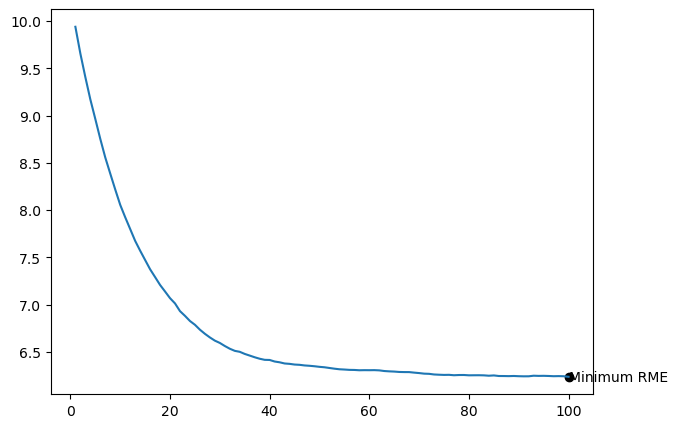

In [11]:
plt.figure(figsize=(7,5))

plt.plot(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1), 
         xgb_reg.evals_result()['validation_0']['rmse'], label = 'xgboost')
plt.scatter([range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])]], 
            [np.min(xgb_reg.evals_result()['validation_0']['rmse'])], c='k')
plt.text(range(1,len(xgb_reg.evals_result()['validation_0']['rmse'])+1)[np.argmin(xgb_reg.evals_result()['validation_0']['rmse'])], 
         np.min(xgb_reg.evals_result()['validation_0']['rmse'])-.05, "Minimum RME", fontsize=10)

plt.hlines(baseline_rmse, 0,200, linestyle='--',color = 'k',label = 'baseline RMSE')

plt.title("Validation Error. Learning Rate = .05, max depth = 5", fontsize=14)
plt.xlabel("Number of Weak Learners", fontsize=12)
plt.ylabel("RMSE", fontsize=12)
plt.xlim(0,100)
plt.ylim(4,12)
plt.legend()
plt.show()

In [ ]:
print('Baseline RMSE: {}'.format(rmse_base))
print('Linear Regression RMSE: {}'.format(rmse_lr))
print('XGBoost RMSE: {}'.format(rmse_xgb))

Baseline RMSE: 9.925005967818715
Linear Regression RMSE: 6.376145823180819
XGBoost RMSE: 6.156601463455593


# Using `statsmodels`

After discussing with Steven, I've realized that a linear model is probably not correct. So, the stuff below isn't going to be that useful, since it all assumes a linear model. Instead, we need to do a logistic regression.

In [28]:
import statsmodels.api as sm
# import statsmodels.formula.api as smf

In [29]:
# First, scale the data.
scaler = StandardScaler()
X_train_scaled = gpd.GeoDataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

full_model = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()

def perform_f_test(X, full_features, reduced_features):
    X_train_full = X[full_features]
    X_train_reduced = X[reduced_features]

    # Create the models
    full_model = sm.OLS(y_train, sm.add_constant(X_train_full)).fit()
    reduced_model = sm.OLS(y_train, sm.add_constant(X_train_reduced)).fit()

    # Perform the F-test
    f_test = full_model.compare_f_test(reduced_model)

    # Print the results
    print("F-statistic:", f_test[0])
    print("p-value:", f_test[1])

### Travel time only
First, we use the reduced model with only the features `'walking_transit_travel_time'` and `'driving_travel_time'`.

In [30]:
perform_f_test(X_train_scaled, features, ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 113.02506086350964
p-value: 8.63703365820754e-310


Evidently, we should reject the reduced model.

### Education/Employment only

In [31]:
perform_f_test(X_train_scaled, features, features_education + features_employment)

F-statistic: 9.317898207246134
p-value: 1.1175074860856775e-25


Evidently, we should reject the reduced model.

### Education/Employment + travel time only

In [32]:
perform_f_test(X_train_scaled, features, features_education + features_employment + ['walking_transit_travel_time', 'driving_travel_time'])

F-statistic: 9.927278715806612
p-value: 3.3448646873176454e-25


Evidently, we should reject the reduced model.

### Education/Employment + travel time only + median income

In [33]:
perform_f_test(X_train_scaled, features, features_education + features_employment 
               + ['walking_transit_travel_time', 'driving_travel_time', 'median_household_income_cen'])

F-statistic: 10.348834792471697
p-value: 3.8772303011757515e-25


### All but race

In [34]:
perform_f_test(X_train_scaled, features, features_transit_type + features_education + features_employment 
               + ['median_household_income_cen', 'median_age_cen', 'polling_accessible', 'walking_transit_travel_time', 
                  'driving_travel_time'])

F-statistic: 18.915610756110237
p-value: 3.408985314803824e-21


# Logistic Regression

## Unweighted

<!-- We use weighted logistic regression. The labels are "1" for "voted" and "0" for "didn't vote". The weights for "1" are
$$ \frac{\mathrm{VoterTurnoutPercentage}}{100} \cdot \mathrm{\mathrm{elligible\_voting\_population}},$$
while the weights for "0" are
$$ \left(1 - \frac{\mathrm{VoterTurnoutPercentage}}{100}\right) \cdot \mathrm{\mathrm{elligible\_voting\_population}}.$$

WARNING! For the moment, we're using `total_population` rather than `elligible_voting_population`, since we didn't pull the latter. -->
We use logistic regression. We see below that the median voter turnout percentage is approximately 70, so we used that as a cutoff percentage for labelling.

In [207]:
from sklearn.linear_model import LogisticRegression

In [231]:
print(data['VoterTurnoutPercentage'].median())
cutoff_percentage = 70

69.265


In [ ]:
# A function to create the labels based on the cutoff percentage.
def make_labels(y_train):
    return 1.0*(y_train >= cutoff_percentage)

# Create the pipeline.
pipe_logr = Pipeline([('scale', StandardScaler()),
                      ('logr', LogisticRegression())])

# Do the logistic regression.
pipe_logr.fit(X_train, make_labels(y_train))

# Score!
pipe_logr.score(X_val, make_labels(y_val))

0.8424242424242424

As can be seen from the bar chart below, the features like `graduate_degree_percent_cen` and `high_school_percent_cen` have the most impact on voter turnout (or more precisely, whether the voter turnout is above 70%). This aligns with the results of XGBoost.

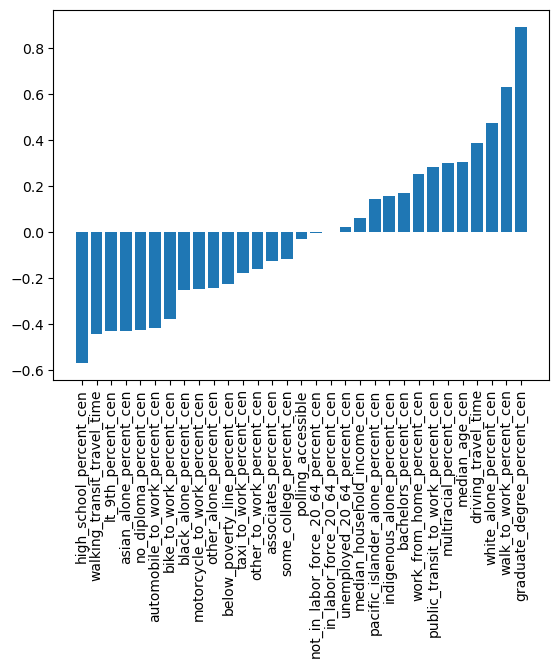

In [229]:
# Create the dictionary of feature names and coefficients
coeff_dict = dict(zip(features, pipe_logr.named_steps['logr'].coef_[0]))

# Convert the dictionary to a DataFrame
coeff_df = pd.DataFrame(coeff_dict.items(), columns=['Feature', 'Coefficient'])

coeff_df.sort_values('Coefficient', inplace=True)
xx = np.arange(coeff_df.shape[0])
plt.bar(xx, coeff_df['Coefficient'])
plt.gca().xaxis.set_ticks(xx)
plt.gca().xaxis.set_ticklabels(coeff_df['Feature'], rotation=90)
plt.show()

In [211]:
# class DataDuplicator(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass

#     def fit(self, X, y=None):
#         return self
    
#     def transform(self, X, y=None):
#         X_duplicated = np.vstack([X, X])
#         return X_duplicated

# def get_labels(X):
#     # 0's come first!
#     return np.concatenate([np.zeros(len(X)), np.ones(len(X))])

# def get_weights(data):
#     return pd.concat([(1-data['VoterTurnoutPercentage']/100) * data['total_population_cen'],
#                       data['VoterTurnoutPercentage']/100 * data['total_population_cen']])

In [212]:
# pipe_logr = Pipeline([('scale', StandardScaler()),
#                       ('dup', DataDuplicator()),
#                       ('logr', LogisticRegression())])

# pipe_logr.fit(X_train, get_labels(X_train), logr__sample_weight=get_weights(data_train))
# pipe_logr.score(X_train, get_labels(X_train), logr__sample_weight=get_weights(data_train))

## Weighted Logistic Regression
The only difference here is that we're weighting each precinct by `total_population_cen`.

In [254]:
def make_weights(data):
    return data['total_population_cen']

# Create the pipeline.
pipe_wt_logr = Pipeline([('scale', StandardScaler()),
                         ('wt_logr', LogisticRegression())])

# Do the logistic regression.
pipe_wt_logr.fit(X_train, make_labels(y_train), wt_logr__sample_weight=data_train['total_population_cen'])

# Score!
pipe_wt_logr.score(X_val, make_labels(y_val), wt_logr__sample_weight=data_val['total_population_cen'])

0.8515151515151516

## Cross Validation

In [255]:
kfold_logr = KFold(n_splits=5, shuffle=True)
X_train_with_pop = data_train[features + ['total_population_cen']]

# scores will hold the cross validation score of each model.
scores = np.zeros((2,5))

for i, (train_index, val_index) in enumerate(kfold_logr.split(X_train_with_pop, y_train)):
    ## get the kfold training data
    X_train_train = X_train_with_pop.iloc[train_index,:][features]
    sample_weight_train = X_train_with_pop.iloc[train_index,:]['total_population_cen']
    y_train_train = y_train.iloc[train_index]
    
    ## get the holdout data
    X_train_holdout = X_train_with_pop.iloc[val_index,:][features]
    sample_weight_holdout = X_train_with_pop.iloc[val_index,:]['total_population_cen']
    y_train_holdout = y_train.iloc[val_index]

    ## train the models
    pipe_logr.fit(X_train_train, make_labels(y_train_train))
    pipe_wt_logr.fit(X_train_train, make_labels(y_train_train), wt_logr__sample_weight=sample_weight_train)

    ## compute the scores
    scores[0,i] = pipe_logr.score(X_train_holdout, make_labels(y_train_holdout))
    scores[1,i] = pipe_wt_logr.score(X_train_holdout, make_labels(y_train_holdout), wt_logr__sample_weight=sample_weight_holdout)

In [256]:
scores

array([[0.81439394, 0.84790875, 0.82889734, 0.82509506, 0.84790875],
       [0.81060606, 0.84410646, 0.82509506, 0.82129278, 0.84410646]])

Evidently, the weighted logistic regression performs basically exactly as well as the unweighted logistic regression.